**IMPORTANT NOTE: The simulations have been done just with the last 100000 samples, to make simulations easier and faster. This is the reason why the results of the predictions are not too good.** 

In [0]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from __future__ import print_function, division
import numpy as np
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.models import load_model
from keras import optimizers
from keras.regularizers import l1

Using TensorFlow backend.


Upload of the data

In [3]:
df = pd.read_csv('HFT.csv')
df

,feature_1,feature_2,feature_3,label
0,0.515301,0.72,0.710953,0
1,0.515301,0.72,0.710953,0
2,0.515301,0.72,0.710953,0
3,0.515301,0.72,0.710953,0
4,0.515301,0.72,0.710953,0
5,0.515301,0.72,0.710953,0
6,0.515301,0.72,0.710953,0
7,0.515301,0.72,0.710953,0
8,0.515301,0.72,0.710953,0
9,0.515301,0.72,0.710953,0


In [4]:
df.head()

,feature_1,feature_2,feature_3,label
0,0.515301,0.72,0.710953,0
1,0.515301,0.72,0.710953,0
2,0.515301,0.72,0.710953,0
3,0.515301,0.72,0.710953,0
4,0.515301,0.72,0.710953,0


We consider a univariate prediction problem where the time series is given by 'feature_3' in the data frame.

In [0]:
use_features = ['feature_3'] # continuous input
target = 'feature_3' # continuous output

**QUESTION 1**. Confirm that the data is stationary by applying the augmented Dickey-Fuller test.

In [6]:
adf, p, usedlag, nobs, cvs,aic=sm.tsa.stattools.adfuller(df[use_features[0]][:200000].values)
print(adf,p, nobs, cvs)

-3.970572659864128 0.0015726872209318426 199919 {'1%': -3.430382710167448, '5%': -2.8615544574611698, '10%': -2.566777695186804}


Since -3.97 < -3.43, we reject the null at the 99% confidence level as the p-value is smaller than 0.01. This suggests that the **time series is** **stationary**.

**IMPORTANT NOTE**: We are going to take just the last 100000 samples of the dataset to make simulations easier and faster.

In [0]:
df = df[-100000:]

In [9]:
len(df)

100000

**QUESTION 2**. Estimate the partial autocorrelation and determine the optimum lag at the 99% confidence level.

In [0]:
pacf=sm.tsa.stattools.pacf(df[use_features], nlags=30)

We find the first lag which isn't significant at the 99% level and automatically determine the number of lags needed in our autoregressive model as one below this value

In [0]:
n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(df[use_features])))==False)[0][0] -1

This may lead to a high order model, with more lags than strictly necessary. We could view this value, informally, as an upper bound on the number of lags needed. We can also simply identify the order of the model based on the plot of the PACF. In this case, a minimum of 2 lags appears satisfactory, although more may be needed.

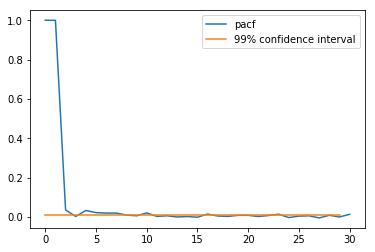

In [13]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(len(df[use_features]))]*30, label='99% confidence interval')
plt.legend()

In [0]:
n_steps = 20 # number of lags to include in the model, based on the plot

**QUESTION 3 a**. Evaluate the MSE in-sample and out-of-sample using 4 filters.

**Split the data into training and test for scaling the data**

In [0]:
train_weight = 0.8
split = int(len(df)*train_weight)
# train
df_train = df.iloc[:split]

# computation of mu and sigma
mu = np.float(df_train[use_features].mean())
sigma = np.float(df_train[use_features].std())

# standarized train
std_df_train = df_train[use_features].apply(lambda x: (x - mu) / sigma)

# test
df_test = df.iloc[split:]

# standarized test
std_df_test = df[use_features].apply(lambda x: (x - mu) / sigma).iloc[split:]


In [0]:
std_df_train_np = np.transpose((std_df_train[use_features].to_numpy()))
std_df_test_np = np.transpose((std_df_test[use_features].to_numpy()))
std_df_train_np = std_df_train_np[0]
std_df_test_np = std_df_test_np[0]
                              

In [26]:
std_df_train_np

array([ 0.98746526,  0.98743772,  0.98695601, ..., -1.28239596,
       -1.28206897, -1.28209906])

**Prediction of high frequency mid-prices with a single hidden layer CNN using 4 filters**

Functions definition

In [0]:
def make_timeseries_regressor(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):

    model = Sequential((
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size, nb_input_series)),
        Flatten(),
        Dense(nb_outputs, activation='linear', activity_regularizer=l1(0.001)), 
    ))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

In [0]:
def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0]
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    y = timeseries[window_size:]
    q = np.atleast_3d([timeseries[-window_size:]])
    return X, y, q

In [0]:
np.set_printoptions(threshold=25)
window_size = n_steps
nb_filter = 4
filter_length = 5
timeseries_test = std_df_test_np 
timeseries_train = std_df_train_np 

Evaluate time series

In [39]:
timeseries_train = np.atleast_2d(timeseries_train)
if timeseries_train.shape[0] == 1:
    timeseries_train = timeseries_train.T       # Convert 1D vectors to 2D column vectors

timeseries_test = np.atleast_2d(timeseries_test)
if timeseries_test.shape[0] == 1:
    timeseries_test = timeseries_test.T       # Convert 1D vectors to 2D column vectors

nb_samples, nb_series = timeseries_train.shape
print('\n\nTimeseries ({} samples by {} series):\n'.format(nb_samples, nb_series), timeseries_train)
model = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model.input_shape, model.output_shape, nb_filter, filter_length))
model.summary()

X_train, y_train, q_train = make_timeseries_instances(timeseries_train, window_size)
X_test, y_test, q_test = make_timeseries_instances(timeseries_test, window_size)

print('\n\nInput features:', X_train, '\n\nOutput labels:', y_train, '\n\nQuery vector:', q_train, sep='\n')

model.fit(X_train, y_train, nb_epoch=25, batch_size=2, validation_data=(X_test, y_test))

pred = model.predict(X_test)
print('\n\nactual', 'predicted', sep='\t')
for actual, predicted in zip(y_test, pred.squeeze()):
    print(actual.squeeze(), predicted, sep='\t')
print('next', model.predict(q_train).squeeze(), sep='\t')



Timeseries (80000 samples by 1 series):
 [[ 0.98746526]
 [ 0.98743772]
 [ 0.98695601]
 ...
 [-1.28239596]
 [-1.28206897]
 [-1.28209906]]






Model with input size (None, 20, 1), output size (None, 1), 4 conv filters of length 5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 4)             24        
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(20, 1), filters=4, kernel_size=5)`
  after removing the cwd from sys.path.




Input features:
[[[ 0.98746526]
  [ 0.98743772]
  [ 0.98695601]
  ...
  [ 0.98581949]
  [ 0.98581949]
  [ 0.98557638]]

 [[ 0.98743772]
  [ 0.98695601]
  [ 0.98690771]
  ...
  [ 0.98581949]
  [ 0.98557638]
  [ 0.98538146]]

 [[ 0.98695601]
  [ 0.98690771]
  [ 0.98690771]
  ...
  [ 0.98557638]
  [ 0.98538146]
  [ 0.98538146]]

 ...

 [[-1.28912081]
  [-1.28912081]
  [-1.28912081]
  ...
  [-1.28030257]
  [-1.27998214]
  [-1.28209906]]

 [[-1.28912081]
  [-1.28912081]
  [-1.28891912]
  ...
  [-1.27998214]
  [-1.28209906]
  [-1.28239596]]

 [[-1.28912081]
  [-1.28891912]
  [-1.28781256]
  ...
  [-1.28209906]
  [-1.28239596]
  [-1.28206897]]]


Output labels:
[[ 0.98538146]
 [ 0.98538146]
 [ 0.98538146]
 ...
 [-1.28239596]
 [-1.28206897]
 [-1.28209906]]


Query vector:
[[[-1.28891912]
  [-1.28781256]
  [-1.28421859]
  [-1.28071174]
  [-1.28071174]
  [-1.28039672]
  [-1.27557537]
  [-1.27489987]
  [-1.27527425]
  [-1.27494127]
  [-1.27494127]
  [-1.27494127]
  [-1.2748664 ]
  [-1.27961153]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 79980 samples, validate on 19980 samples
Epoch 1/25





79980/79980 [==============================] - 48s 600us/step - loss: 0.0190 - mean_absolute_error: 0.0373 - val_loss: 0.0143 - val_mean_absolute_error: 0.0534
Epoch 2/25
79980/79980 [==============================] - 47s 588us/step - loss: 0.0013 - mean_absolute_error: 0.0127 - val_loss: 0.0154 - val_mean_absolute_error: 0.0615
Epoch 3/25
79980/79980 [==============================] - 47s 587us/step - loss: 0.0012 - mean_absolute_error: 0.0115 - val_loss: 0.0132 - val_mean_absolute_error: 0.0476
Epoch 4/25
79980/79980 [==============================] - 45s 564us/step - loss: 0.0012 - mean_absolute_error: 0.0113 - val_loss: 0.0134 - val_mean_absolute_error: 0.0474
Epoch 5/25
79980/79980 [==============================] - 46s 575us/step - loss: 0.0012 - mean_absolute_error: 0.0111 - val_loss: 0.0133 - val_mean_absolute_error: 0.0473
Epoch 6/25
79980/79980 [==============================] - 45s 568us/step - loss: 0.0012 -

**Model prediction**

In [0]:
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

**Model performance**

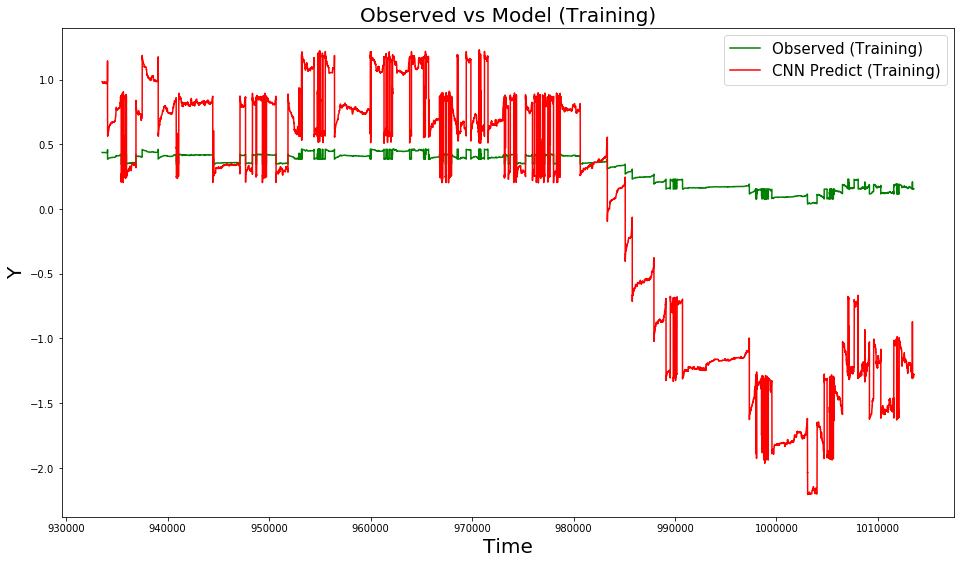

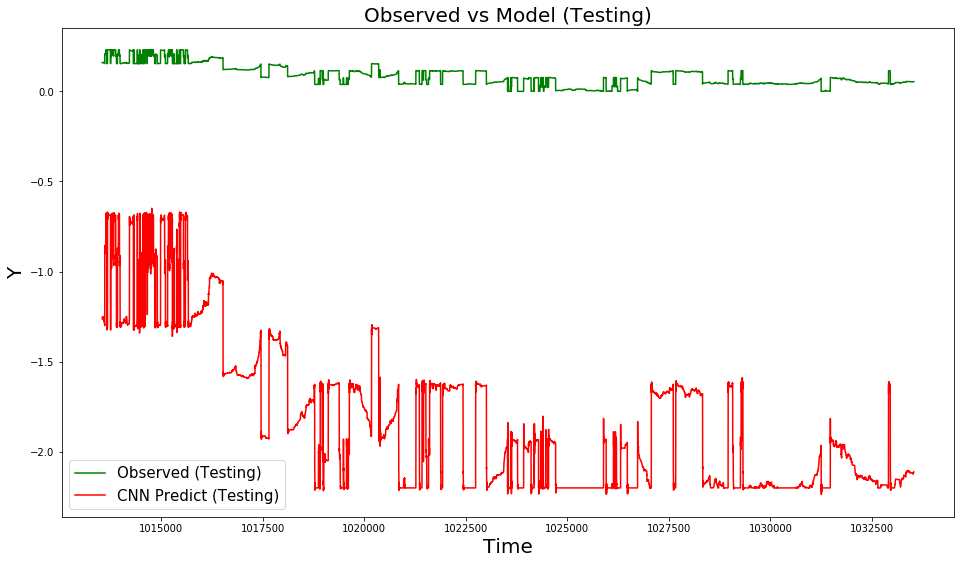

In [45]:
fig = plt.figure(figsize=(16,9))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_features][n_steps:], color="g", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], pred_train[:, 0], color="r", label="CNN Predict (Training)")


plt.legend(loc="best", fontsize=15)
plt.title('Observed vs Model (Training)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)


fig = plt.figure(figsize=(16,9))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_features][n_steps:], color="g", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], pred_test[:, 0], color="r", label="CNN Predict (Testing)")

plt.legend(loc="best", fontsize=15)
plt.title('Observed vs Model (Testing)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

**Mean Squared Error (MSE) calculation**

In [47]:
MSE_train = mean_squared_error(df_train[use_features][n_steps:], pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_features][n_steps:], pred_test[:, 0])
print(MSE_test)

0.8671925941180387
3.7632025636822513


**QUESTION 3 b**. Implementation for models with more than 4 filters

**5 filters**

In [48]:
# CNN creation
nb_filter = 5
model_5 = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model_5.input_shape, model_5.output_shape, nb_filter, filter_length))
model_5.summary()

# fit the model
model_5.fit(X_train, y_train, nb_epoch=25, batch_size=2, validation_data=(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(20, 1), filters=5, kernel_size=5)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys




Model with input size (None, 20, 1), output size (None, 1), 5 conv filters of length 5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 16, 5)             30        
_________________________________________________________________
flatten_2 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________
Train on 79980 samples, validate on 19980 samples
Epoch 1/25
79980/79980 [==============================] - 55s 688us/step - loss: 0.0036 - mean_absolute_error: 0.0198 - val_loss: 0.0029 - val_mean_absolute_error: 0.0263
Epoch 2/25
79980/79980 [==============================] - 54s 674us/step - l

In [54]:
# make predictions
pred_test_5 = model_5.predict(X_test)
pred_train_5 = model_5.predict(X_train)

# train MSE and test MSE
MSE_train_5 = mean_squared_error(df_train[use_features][n_steps:], pred_train_5[:, 0])
print(MSE_train_5)
MSE_test_5 = mean_squared_error(df_test[use_features][n_steps:], pred_test_5[:, 0])
print(MSE_test_5)

0.8384019519632883
3.9513643948262103


**10 filters**

In [50]:
# CNN creation
nb_filter = 10
model_10 = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model_10.input_shape, model_10.output_shape, nb_filter, filter_length))
model_10.summary()

# fit the model
model_10.fit(X_train, y_train, nb_epoch=25, batch_size=2, validation_data=(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(20, 1), filters=10, kernel_size=5)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys




Model with input size (None, 20, 1), output size (None, 1), 10 conv filters of length 5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 16, 10)            60        
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 161       
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________
Train on 79980 samples, validate on 19980 samples
Epoch 1/25
79980/79980 [==============================] - 57s 710us/step - loss: 0.0017 - mean_absolute_error: 0.0153 - val_loss: 0.0022 - val_mean_absolute_error: 0.0120
Epoch 2/25
79980/79980 [==============================] - 56s 698us/step - 

In [55]:
# make predictions
pred_test_10 = model_10.predict(X_test)
pred_train_10 = model_10.predict(X_train)

# train MSE and test MSE
MSE_train_10 = mean_squared_error(df_train[use_features][n_steps:], pred_train_10[:, 0])
print(MSE_train_10)
MSE_test_10 = mean_squared_error(df_test[use_features][n_steps:], pred_test_10[:, 0])
print(MSE_test_10)

0.8669030140715047
3.9518618676059556


**20 filters**

In [51]:
# CNN creation
nb_filter = 20
model_20 = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model_20.input_shape, model_20.output_shape, nb_filter, filter_length))
model_20.summary()

# fit the model
model_20.fit(X_train, y_train, nb_epoch=25, batch_size=2, validation_data=(X_test, y_test))



Model with input size (None, 20, 1), output size (None, 1), 20 conv filters of length 5
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 16, 20)            120       
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 321       
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(20, 1), filters=20, kernel_size=5)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 79980 samples, validate on 19980 samples
Epoch 1/25
79980/79980 [==============================] - 60s 751us/step - loss: 0.0021 - mean_absolute_error: 0.0168 - val_loss: 0.0038 - val_mean_absolute_error: 0.0457
Epoch 2/25
79980/79980 [==============================] - 61s 759us/step - loss: 0.0013 - mean_absolute_error: 0.0118 - val_loss: 0.0033 - val_mean_absolute_error: 0.0370
Epoch 3/25
79980/79980 [==============================] - 60s 751us/step - loss: 0.0013 - mean_absolute_error: 0.0115 - val_loss: 0.0036 - val_mean_absolute_error: 0.0206
Epoch 4/25
79980/79980 [==============================] - 59s 742us/step - loss: 0.0012 - mean_absolute_error: 0.0109 - val_loss: 0.0021 - val_mean_absolute_error: 0.0137
Epoch 5/25
79980/79980 [==============================] - 60s 750us/step - loss: 0.0012 - mean_absolute_error: 0.0110 - val_loss: 0.0019 - val_mean_absolute_error: 0.0082
Epoch 6/25
79980/79980 [==============================] - 60s 746us/step - loss: 0.0012 - mean_

In [56]:
# make predictions
pred_test_20 = model_20.predict(X_test)
pred_train_20 = model_20.predict(X_train)

# train MSE and test MSE
MSE_train_20 = mean_squared_error(df_train[use_features][n_steps:], pred_train_20[:, 0])
print(MSE_train_20)
MSE_test_20 = mean_squared_error(df_test[use_features][n_steps:], pred_test_20[:, 0])
print(MSE_test_20)

0.8781652289061013
3.9927952716169557


**50 filters**

In [57]:
# CNN creation
nb_filter = 50
model_50 = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model_50.input_shape, model_50.output_shape, nb_filter, filter_length))
model_50.summary()

# fit the model
model_50.fit(X_train, y_train, nb_epoch=25, batch_size=2, validation_data=(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(20, 1), filters=50, kernel_size=5)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys




Model with input size (None, 20, 1), output size (None, 1), 50 conv filters of length 5
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 16, 50)            300       
_________________________________________________________________
flatten_5 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 801       
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________
Train on 79980 samples, validate on 19980 samples
Epoch 1/25
79980/79980 [==============================] - 63s 786us/step - loss: 0.0024 - mean_absolute_error: 0.0182 - val_loss: 0.0050 - val_mean_absolute_error: 0.0563
Epoch 2/25
79980/79980 [==============================] - 61s 757us/ste

In [58]:
# make predictions
pred_test_50 = model_50.predict(X_test)
pred_train_50 = model_50.predict(X_train)

# train MSE and test MSE
MSE_train_50 = mean_squared_error(df_train[use_features][n_steps:], pred_train_50[:, 0])
print(MSE_train_50)
MSE_test_50 = mean_squared_error(df_test[use_features][n_steps:], pred_test_50[:, 0])
print(MSE_test_50)

0.8738561211370773
3.9694702898929966


**QUESTION 4**. Apply L1 regularization to reduce the variance.

To apply an L1 regularization it has been added the function "keras.regularizers.l1(0.001)" to the Dense layer of the CNN. We have select a parameter of 0.001

**QUESTION 5**. Determine whether the model error is white noise or is auto-
correlated by applying the Ljung-Box test.

In [0]:
T=100000
residual=df_train[use_features][n_steps:(n_steps+T)].values-(sigma*pred_train[:T, 0]+mu)
lb,p=sm.stats.diagnostic.acorr_ljungbox(residual, lags=10, boxpierce=False)

**The Box-Ljung test statistics:**

In [0]:
lb

**The p-values:**

In [0]:
p